# Rabbit mMS calibration
<br>
This notebook is based on Sam's analyze_paramaters notebook, and uses restitution curve emulators to calibrate the modified Mitchell Schaeffer cardiac model using observations of APD restitution in rabbit ventricles.

In [1]:
 # choose the data table to load
table_filename = "../stripSimMMS/data/5d_500.hdf5"

# S1 intervals (ms)
S1 = 240

# figures directory
FIGDIR = "../figures"

In [2]:
# load modules
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy.ndimage.filters import gaussian_filter

from sklearn.decomposition import PCA, KernelPCA
from pygam import LinearGAM, te, ExpectileGAM
from pygam import s as spline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from scipy.optimize import least_squares
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import GPy

import emcee # note: uses the log likelihood (unsurprisingly)

from SALib.sample import saltelli
from SALib.analyze import sobol

# Sam's modules
print(os.getcwd())
# import hdf5Utils as hu # https://github.com/samcoveney/hdf5Utils
# troublesome import, so these functions are defined below instead

# notebook display options
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

/Users/richard/Google Drive/RabbitCalibration/notebooks


In [3]:
# MMS modeling functions

v_gate = 0.1 # fixed parameter

def paramsToFeatures(data):
    """Convert from MMS parameters to 'features', accounting for feature being tau_out"""
    
    D, t_in, t_out, t_open, t_close = [d for d in data.T]
    h_min = 1 / ( 1 + t_out/(4*t_in) * (1 - v_gate)**2 )
    APD_max = t_close * np.log( 1.0 / h_min )
    CV_max = 0.5 * (1 - 2*v_gate) * np.sqrt(2*D/t_in)
    return np.hstack([ CV_max[:,None], t_in[:,None], t_out[:,None], t_open[:,None], APD_max[:,None] ])

def featuresToParams(data):
    """Convert from MMS 'features' to parameters, accounting for feature being tau_out"""
    
    CV_max, t_in, t_out, t_open, APD_max = [d for d in data.T]
    D = 0.5*t_in * ( 2*CV_max / (1 - 2*v_gate) )**2
    h_min = 1 / ( 1 + t_out/(4*t_in) * (1 - v_gate)**2 )
    t_close = -APD_max / np.log(h_min)
    return np.hstack([ D[:,None], t_in[:,None], t_out[:,None], t_open[:,None], t_close[:,None] ])

pnames = ["D", "tau_in", "tau_out", "tau_open", "tau_close"]
fnames = ["CV_max", "tau_in", "tau_out", "tau_open", "APD_max"]

def logistic_func(x, a, b, c, APD90_S1 = 0):
    """Logistic function that fits the (monotonic part of) the CV(S2) and APD(S2) restitution curves.
       If using APD_90, then x should be DI instead of S2"""
    return a * ( 1 - b*np.exp( -((x + APD90_S1))/c ) )

MINMAX = [[0.010, 0.150], [0.01, 0.30], [1, 30], [65, 215], [120, 270]]
NAMES = ["CVmax", "Tin", "Tout", "Topen", "APDmax"]

In [4]:
"""
   h5pyUtils.py
   Module with utility functions for handling HDF5 files via h5py module.
   Created: 10-Feb-2020
   Author:  Sam Coveney
"""


from __future__ import print_function
import os.path
import h5py
import numpy as np


def createHDF5(filename):
    """Create an empty HDF5 file with some groups but no datasets."""

    if os.path.isfile(filename):
        print ("File {:s} exists, so doing nothing.".format(filename))
        return
    else:
        print ("File does not exist, creating new file.".format(filename))

    FILE = h5py.File(filename, "a")

    FILE.close()


def scanHDF5(filename, recursive=True, tab_step=2):
    """Display the contents of a HDF5 file.
    
       Modified version of this: https://stackoverflow.com/questions/43371438/how-to-inspect-h5-file-in-python 
    """
    def scan_node(g, tabs=0):

        if tabs > 0:
            print(' ' * tabs + "|--", g.name.split("/")[-1])
        else:
            print("\n=" + "="*len(filename) + "=" + "\n {:s} ".format(filename) + "\n-" + "-"*len(filename) + "-" )

        for k, v in g.items():
            if isinstance(v, h5py.Dataset):
                print(' ' * tabs + ' ' * tab_step + '  >', v.name.split("/")[-1])
            elif isinstance(v, h5py.Group) and recursive:
                scan_node(v, tabs = tabs + tab_step)

    with h5py.File(filename, 'r') as f:
        scan_node(f)
        f.close()
        print("=" + "="*len(filename) + "=\n")


def deleteGroup(filename, group):
    """Delete a group."""

    FILE = h5py.File(filename, "r+")

    try:
        del FILE[group]
        print("[DELETE]: <{:s}> group deleted.".format(group))
    except:
        pass

    FILE.close()


def createGroup(filename, group, subgroups = []):
    """Create a new group after first deleting the old one."""

    #deleteGroup(filename, group)
    try:
        FILE = h5py.File(filename, "r+")
        GROUP = FILE.create_group(group)
        print("[CREATE]: <{:s}> group created.".format(group))

        for sg in subgroups:
            GROUP.create_group(sg)
    except:
        print("Group exists, so not creating a new one.")
        pass

    FILE.close()


def getDataset(filename, group, dataset):
    """Return a NumPy dataset under the supplied group name."""

    FILE = h5py.File(filename, "r")

    GROUP = FILE[group]

    try:
        data = np.array(GROUP[dataset])
    except:
        print("[ERROR]: <{:s}> dataset in <{:s}> group does not exist, returning None.".format(dataset, group))
        return None

    FILE.close()

    return data


def deleteDataset(filename, group, dataset):
    """Delete a dataset under the supplied group name."""

    FILE = h5py.File(filename, "r+")

    GROUP = FILE[group]

    try:
        del GROUP[dataset]
        print("[DELETE]: <{:s}> dataset in <{:s}> group deleted.".format(dataset, group))
    except:
        pass

    FILE.close()


def createDataset(filename, group, dataset, data):
    """Create a NumPy dataset under the supplied group name."""

    deleteDataset(filename, group, dataset)

    FILE = h5py.File(filename, "r+")

    GROUP = FILE[group]

    GROUP.create_dataset(dataset, data = data)

    print("[CREATE]: <{:s}> dataset in <{:s}> group created.".format(dataset, group))

    FILE.close()


## PCA of restitutions curves

From simulation results:

* 1) upsample S2; I have the CV(S2) restitution curves for S1: 600ms, in the form of the parameters to a logistic function that fits the resitution curves. This allows me to calculate the CV(S2) curves at any S2 resolution 
* 2) do PCA on the upsampled curves.
* 3) plot parameters (or features) agains PCA components

(I also have the APD(S2) curves. I have all of these curves for S1: 600, 450, 300)

In [5]:
# load the simulation results
# ---------------------------
samples = 500

scanHDF5(table_filename, recursive=True, tab_step=2)

params = getDataset(table_filename, "/", "params")
all_data_S1S2 = getDataset(table_filename, str(S1), "300")
# all_data_S1S2S3 = getDataset(table_filename, str(S1), "300")

table_CV = all_data_S1S2[0:samples,0]
table_APD = all_data_S1S2[0:samples,1]
table_ERP = all_data_S1S2[0:samples,2]
CVrest    = all_data_S1S2[0:samples,[3,4,5]]
APDrest   = all_data_S1S2[0:samples,[6,7,8]] # NOTE: changed here
#newERP    = all_data_S1S2S3[:,2]

print("shape of params array: ", params.shape)
#print("first row of params: ", params[0,:])
print("shape of CV and APD restitution arrays: ", APDrest.shape, " and ", CVrest.shape)
#print("first row of CVrest: ", CVrest[0,:])
#print("first row of APDrest: ", APDrest[0,:])


# ignore ERP for rabbit analysis

features = paramsToFeatures(params)
print("shape of features array: ", features.shape)

print("Initial number:", params.shape[0])

# filter out various rows of data
# -------------------------------

# filter out NaN results
condition = ~( ( np.isnan(CVrest) | np.isnan(APDrest) ).any(1) \
              # ( (ERPrest > 600) | np.isnan(ERPrest) ).any(1) \
              #| np.isnan(newERP) \ #removed ERP(S1,S2) not using here
             )
print("condition:", condition.sum())

if False:
    # filter out extreme outliers
    med = np.nanmedian(APDrest, axis = 0)
    mad = np.nanmedian(np.abs(APDrest - med), axis = 0)
    outliers_APD = ( (APDrest < (med - 6*mad)) | (APDrest > (med + 6*mad)) ).any(1)

    # filter out extreme outliers
    med = np.nanmedian(CVrest, axis = 0)
    mad = np.nanmedian(np.abs(CVrest - med), axis = 0)
    outliers_CV = ( (CVrest < (med - 6*mad)) | (CVrest > (med + 6*mad)) ).any(1)

    outliers = outliers_APD | outliers_CV
    #print("outliers:", outliers)

    condition = condition * ~outliers
    print("condition discarding outliers:", condition.sum())

# enforce reasonable ERP
# NOTE: may induce structure in the table and mess up the sensitivity analysis...
#condition = condition #* (table_ERP < 300) #  using 300 as max
#print("condition discarding outliers and bad ERP:", condition.sum())

#CVcond = (table_CV > 0.1)
#condition = condition * CVcond
#print("condition discarding outliers and bad ERP and very low CV:", condition.sum())

params, features = params[condition], features[condition]
# ERPrest, table_APD = ERPrest[condition], table_APD[condition]
CVrest, APDrest = CVrest[condition], APDrest[condition]
table_ERP = table_ERP[condition]


 ../stripSimMMS/data/5d_500.hdf5 
---------------------------------
  |-- 240
      > 300
    > params

shape of params array:  (500, 5)
shape of CV and APD restitution arrays:  (500, 3)  and  (500, 3)
shape of features array:  (500, 5)
Initial number: 500
condition: 319


### Upsample

In order to perform PCA on the restitution curves, we require a common resolution. Since we have recorded the restitution curves from simulation via the parameters of the logistic function, it is simple to simply calculate the resitution curves at the desired resolution.

In [6]:
# upsample restitutions common S2 resolution
# ------------------------------------------

def upsample(CVrest, APDrest, figsize = (10,5), COLORBAR = False):
    """ Upsample the restitution curves.
        
    """

    S2MIN, S2MAX = 50, 300 #1000
    #NUM = 10*16 + 1
    NUM = S2MAX - S2MIN + 1
    S2 = np.linspace(S2MIN, S2MAX, NUM, endpoint = True)

    # order by ERP because, generally, plots are easier to see
    order = np.argsort(table_ERP)
        
    # create plots of S2 and DI
    ERP_color = (table_ERP - table_ERP.min()) / (table_ERP.max() - table_ERP.min())
    
    # subfigures
    fig, ax = plt.subplots(1,2,figsize = figsize)
    
    for a in range(2):
    
        if a == 0:
            rest = CVrest
            label = "A"
        else:
            rest = APDrest
            label = "B"

        YDATA = np.empty((rest.shape[0], S2.shape[0]))
        S2_new   = np.empty((rest.shape[0], S2.shape[0]))
        YDATA_new = np.empty((rest.shape[0], S2.shape[0]))

        # plot every curve
        for i in order:

            YDATA[i] = logistic_func(S2, *rest[i])

            cut = (S2 <= table_ERP[i] - 20)
            #cut = (S2 <= table_APD[i])

            S2_new[i] = S2
            # DI_new[i] = S2 - logistic_func(S2, *APDrest[i])
            S2_new[i, cut] = np.nan
            YDATA_new[i] = YDATA[i]
            YDATA_new[i, cut] = np.nan

            #plt.plot(S2, YDATA[i], c = cm.jet(ERP_color[i]), ls = "--")
            im = ax[a].plot(S2_new[i], YDATA_new[i], c = cm.inferno(ERP_color[i]), linewidth = 1.0)

        # add the subfigure labels here
        ax[a].text(0.05, 0.90, label,
                    verticalalignment='bottom', horizontalalignment='right',
                    transform=ax[a].transAxes, fontsize=15)
            
            
        # config
        ax[a].set_xlabel("S2 (ms)")
        if a == 0:
            ax[a].set_ylabel("CV(S2) (m/s)")
            YDATA_CV  = YDATA.copy()
        else:
            ax[a].set_ylabel("APD(S2) (ms)")
            YDATA_APD = YDATA.copy()

        # ax[a].set_xlim(table_ERP.min(), S2.max())
        ax[a].set_xlim(S2MIN, S2MAX)
        
        if a == 0:
            ax[a].set_ylim(0.0, None)
        else:
            ax[a].set_ylim(50, None)
            
    if COLORBAR == True:
        # make my own mappable
        norm = mpl.colors.Normalize(vmin = table_ERP.min(), vmax = table_ERP.max())
        sm = plt.cm.ScalarMappable(cmap = cm.inferno, norm = norm)
        sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(0,2,N), 
        #             boundaries=np.arange(-0.05,2.1,.1))
        cbar_ax = fig.add_axes([0.9125, 0.125, 0.02, 0.75])
        cbar = fig.colorbar(sm, cax=cbar_ax) #, orientation = "horizontal")
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label("ERP (ms)", fontsize = 10)
    
    # save and plot
    plt.savefig(FIGDIR + "rest.pdf", bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()
    
    return S2, YDATA_CV, YDATA_APD

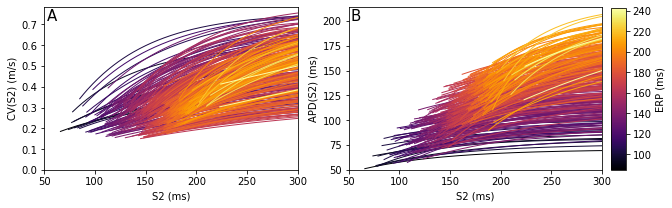

In [7]:
# upsample data to common resolution (display curve only above ERP(S1))

S2, YDATA_CV, YDATA_APD = upsample(CVrest, APDrest, figsize = (10,3), COLORBAR = True)

### PCA

Now we can perform PCA analysis on the collection of upsampled curves.

Here, we use sklearn. Note that the PCA components will be stored in `pca.components_`, the mean will be stored in `pca.mean_`, and in order to project the upsampled restitutions onto the PCA axis (to obtain the PCA coefficients corresponding to each simulated restitution curve) we simple use the `pca.transform()` on the upsampled data.

Restitution curves can then be constructed from a linear combination of PCA components:

\begin{align}
  f(S2) = \mathbf{\beta} \cdot \mathbf{\phi} +  \mu
\end{align}

where $\mu$ is the mean, $\beta$ are the PCA coefficients, and $\phi$ are the PCA components.

These components can be plotted against S2.

The contribution of each PCA component to the variance in the data is printed at the bottom of the next code cell.

In [8]:
# PCA of restitutions
# -------------------

def plotPCA(S2, pca_components, pca_mean):
    """Plots of principle components"""
    
    # plot the PCA components (and mean) against S2
    # ---------------------------------------------

    pca_names = ["PC 1", "PC 2", "PC 3", "PC 4"]
    COLORS = ["turquoise", "cornflowerblue", "orchid"]
    STYLE = ["-", "--", ":"]

    fig, ax = plt.subplots(figsize = (5,2.5))

    # plot PCA components
    for ii in range(pca_components.shape[0]):
        ax.plot(S2, pca_components[ii], label = pca_names[ii], lw = 2, zorder = 1, color = COLORS[ii], ls = STYLE[ii])

    ax.set_xlabel("S2 (ms)")
    ax.set_ylabel("principle components")

    # plot PCA mean
    ax2 = ax.twinx() # create a secondary axis
    ax2.plot(S2, pca_mean, label = "mean", color = "black", ls = "--", lw = 1, zorder = 1)
    ax2.set_ylabel("mean")

    # sort out a common legend
    handles_1, labels_1 = ax.get_legend_handles_labels()
    handles_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(handles_1 + handles_2, labels_1 + labels_2, loc = (0.8, 0.175) )#'lower center')

    plt.show()
    

def doPCA(YDATA, keep = 3):
    """Perform PCA of the restitution curves."""

    # normalize? No, the units are the same, range of each features IS important
    #MEAN  = np.mean(YDATA, axis = 0)
    #STD   = np.std(YDATA, axis = 0)
    #YDATA = (YDATA - MEAN) / STD
    
    # force 3 components
    pca = PCA(n_components = keep, svd_solver = "full")
    pca.fit(YDATA) # features are rows, columns are samples 

    table = "| component | variance | cumsumvar | \n |:---:|---|---| \n"
    csum = 0
    for ii, i in enumerate(100*pca.explained_variance_ratio_):
        csum = csum + i
        table = table + "| {:d} | {:2.3f}% | {:2.3f}% |\n".format(ii+1, i, csum)
    printmd(table)


    # get components
    pca_components = pca.components_
    pca_mean = pca.mean_
    
    # need to project YDATA onto pca space to get coefficients for the original data
    table_coeffs = pca.transform(YDATA)
    table_coeffs_stdev = table_coeffs.std(axis = 0)
    #print("table_coeffs:", table_coeffs.shape)
    
    return pca_components, pca_mean, table_coeffs
    #return pca_components, MEAN, table_coeffs, STD


def varyRestitution(pca_components, pca_mean, table_coeffs, idx):
    """Vary a restitution curve via its coefficients to help visualize meaning of components."""

    rest = np.dot(table_coeffs[idx], pca_components) + pca_mean

    fig, ax = plt.subplots((pca_components.shape[0]), figsize = (10,5))
    if pca_components.shape[0] == 1: ax = [ax]

    tmp_rests = np.empty((10, S2.shape[0]))

    for j in range(table_coeffs.shape[1]):

        ax[j].plot(S2, rest, color = "black")

        for ii, i in enumerate(np.linspace(table_coeffs[:,j].min(), table_coeffs[:,j].max(), 10)):
            tmp = table_coeffs[idx].copy()
            tmp[j] = i
            new_rest = np.dot(tmp, pca_components) + pca_mean
            ax[j].plot(S2, new_rest, alpha = 0.5)

        ax[j].set_ylabel("PC {:d}".format(j+1))
        if j == 2: ax[j].set_xlabel("S2 (ms)")

    plt.show()


In [9]:
# Functions for plotting restitutions
# -----------------------------------

# multi_PCA_plots
def multi_PCA_plots(S2, components, means, figsize = (10,3)): 
    """Plots of principal components"""
    
    # plot the PCA components (and mean) against S2
    # ---------------------------------------------

    pca_names = ["PC 1", "PC 2", "PC 3", "PC 4"]
    COLORS = ["turquoise", "cornflowerblue", "orchid"]
    STYLE = ["--", ":", "-."]

    fig, ax = plt.subplots(1, 2, figsize = figsize, sharey = True)

    for a in range(2):
        
        pca_components = components[a]
        pca_mean = means[a]
    
        # plot PCA components
        for ii in range(pca_components.shape[0]):
            
            SIGN = +1
            if ii == 2: SIGN = -1 if np.argmin(pca_components[ii]) != 0 else +1
            if ii == 0: SIGN = -1 if np.argmin(pca_components[ii]) != 0 else +1
            
            ax[a].plot(S2, SIGN*pca_components[ii], label = pca_names[ii], lw = 2, zorder = 1, color = COLORS[ii], ls = STYLE[ii])

        ax[a].set_xlabel("S2 (ms)")
        if a == 0: ax[a].set_ylabel("principal components")

        # plot PCA mean
        ax2 = ax[a].twinx() # create a secondary axis
        ax2.plot(S2, pca_mean, label = "mean", color = "black", ls = "-", lw = 1, zorder = 1)
        ax2.set_ylabel("mean", rotation = 270, labelpad=15)

        # sort out a common legend
        handles_1, labels_1 = ax[a].get_legend_handles_labels()
        handles_2, labels_2 = ax2.get_legend_handles_labels()
        fig.legend(handles_1 + handles_2, labels_1 + labels_2, loc = (0.7, 0.2) )#'lower center')

        # add the subfigure labels here
        label = "CV(S2)" if a == 0 else "APD(S2)"
        ax[a].text(0.05, 0.90, label,
                      verticalalignment='bottom', horizontalalignment='left',
                      transform=ax[a].transAxes, fontsize=12)
        
        #title = "CV(S2) components" if a == 0 else "APD(S2) components"
        #ax[a].set_title(title)
    
    # plotting
    plt.savefig(FIGDIR + "PCA.pdf", bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()
    

# multi_sensitivity_plots
def multi_sensitivity_plots(sensitivities, legend, figsize = (10,3), COLORS = ["turquoise", "cornflowerblue", "orchid"], title = None):
    """ Sensitivity plots.
        Pass the sensitivity rows that you want and a corresponding LIST of legend labels for them.
    """

    # ---- bar style ---- #
    HATCH = ["", "//", '..']
    #COLORS = ["turquoise", "cornflowerblue", "orchid"]
    labels = ["CVmax", "Tin", "Tout", "Topen", "APDmax"]
    x = np.arange(len(labels))  # the label locations
    width = 0.2
    
    factor = 1.25 if len(legend) == 3 else 0.65
        
    fig, ax = plt.subplots(1,2, figsize = figsize, sharey = True)
    
    for a in range(2):
    
        sensitivity = sensitivities[a]
        
        if sensitivity.ndim < 3: sensitivity = sensitivity[None,:,:] # then it must be both S1 and ST
    
        for ss in range(sensitivity.shape[0]):
    
            alpha = 0.5 if (ss == 0 and sensitivity.shape[0] > 1) else 1.0
      
            for EE, E in enumerate(legend):

                offset = (EE-1)*width*factor
                if EE == 1 and len(legend) == 2: offset = (1)*width*factor

                ax[a].bar(x + offset, sensitivity[ss, EE, :], width, label = E if (ss == 1 or sensitivity.shape[0] == 1) else None,\
                       color = COLORS[EE], hatch = HATCH[EE], alpha = alpha)


            ax[a].set_xticks(x)
            ax[a].set_xticklabels(labels = labels, rotation = 20)
            #ax.tick_params(axis='x', which='major', pad=15)

            ax[0].set_ylim(0,1)
            
        if a == 0: ax[a].set_ylabel("Sensitivity Index")
            
        # add the subfigure labels here
        label = "A" if a == 0 else "B"
        ax[a].text(0.99, 0.90, label,
                      verticalalignment='bottom', horizontalalignment='right',
                      transform=ax[a].transAxes, fontsize=15)

    #plt.tight_layout()

    plt.legend(loc = "upper center", ncol = 3)
    plt.tight_layout()
    
    plt.savefig(FIGDIR + "sens.pdf", bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()
    
    return


# multi_interactions_plot
def multi_interactions_plot(interactions_all, legend, title = None, sobol = False):
    """ Interaction plots.
        Pass the interaction rows that you want and a corresponding LIST of legend labels for them.
    """
    
    labels = ["CVmax", "Tin", "Tout", "Topen", "APDmax"]
    
    fig_scale = 0.8
    fig, ax = plt.subplots(2, len(legend),\
                figsize = (4.15*len(legend)*fig_scale,3.6*2*fig_scale), sharey = False, sharex = True)

    x = np.arange(len(labels))  

        #VMIN, VMAX = interactions[-2:].min(), interactions[-2:].max()
    VMAX = np.max( [ np.abs(interactions_all[0]).max() , np.abs(interactions_all[1]).max() ] )
    if sobol == False:
        VMIN = -VMAX
        cmap = "RdBu_r"
    else:
        VMIN = 0.0
        cmap = colormap(plt.get_cmap('magma_r'), 0.0, 1.0)
    
    for a in range(2):
        
        interactions = interactions_all[a]
    

        for EE, E in enumerate(legend):
    # extent=[-1,5,-1,5], \
            inter = interactions[EE,:].copy()
            #inter[inter < 1e-8] = 0.0 #-1e-8
            np.fill_diagonal(inter, 0.0)
    
            im = ax[a,EE].imshow(inter, \
                               label = E, vmin = VMIN, vmax = VMAX, cmap = cmap)

            #annotate_heatmap(im, valfmt="{x:.1f}", size=7, textcolors = ["red","black"], threshold = 0)

            # sort out ticks, axes, labels
            # ----------------------------
            if EE == 0:
                ax[a,EE].set_yticks(x)
                ax[a,EE].set_yticklabels(labels = labels, fontsize = 10)
            else:
                ax[a,EE].set_yticklabels(labels = [], fontsize = 10)
            #    ax[a,EE].set_yticks([])

            ax[a,EE].set_xticks(x)
            ax[a,EE].set_xticklabels(labels = labels, rotation = 20, fontsize = 10)#, rotation='vertical') 

            # set title
            #if a == 0:
            subtit = "CV(S2) " if a == 0 else "APD(S2) "
            ax[a,EE].set_title(subtit + E, Y = 1.0)
            #ax[i,j].legend(loc = "upper center")

            #gca = plt.gca()

            # Loop over data dimensions and create text annotations.
            if sobol == True:
                for i in range(5):
                    for j in range(5):
                        if i != j:
                            val = inter[i,j]
                            tc = "w" if np.abs(val) > 0.5*VMAX else "black" 
                            tt = "{:1.2f}".format(val)
                            if val >= 0.01:
                                text = ax[a,EE].text(j, i, "{:s}".format(tt),\
                                               ha="center", va="center", color=tc,\
                                               fontsize = 10, fontweight = "bold")
            
            if sobol == False:
                for i in range(5):
                    for j in range(5):
                        if i != j:
                            val = interactions[EE, i,j]
                            tc = "w" if np.abs(val) > 0.6*VMAX else "black" 
                            tt = "+" if val > 0 else "-"
                            text = ax[a,EE].text(j, i, "{:s}".format(tt),\
                                               ha="center", va="center", color=tc,\
                                               fontsize = 15, fontweight = "bold")


        #cbar_ax = fig.add_axes([0.125, 0.05, 0.75, 0.05]) # horizontal
        cbar_ax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
        cbar = fig.colorbar(im, cax=cbar_ax) #, orientation = "horizontal")
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label("Interaction Effect", fontsize = 12)

        #cbar = fig.colorbar(im)

        #plt.tight_layout()
        if len(legend) == 3:
            fig.subplots_adjust(wspace=-0.25, hspace=0)
        else:
            fig.subplots_adjust(wspace=-0.125, hspace=0)
            
        fig.subplots_adjust(wspace=-0.3, hspace=0.175)
        
    #plt.tight_layout()
    plt.savefig(FIGDIR + "inter.pdf", bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()

### Do PCA and plot componenents
Here we display the principal components and the variance that they account for.

__PCA for CV(S2) curves__

| component | variance | cumsumvar | 
 |:---:|---|---| 
| 1 | 78.893% | 78.893% |
| 2 | 20.275% | 99.168% |
| 3 | 0.825% | 99.994% |


__PCA for APD(S2) curves__

| component | variance | cumsumvar | 
 |:---:|---|---| 
| 1 | 93.791% | 93.791% |
| 2 | 5.276% | 99.067% |
| 3 | 0.913% | 99.980% |


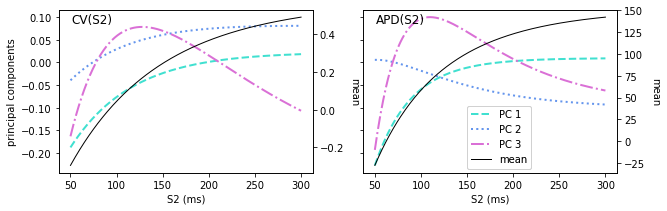

In [10]:
printmd("__PCA for CV(S2) curves__")
pca_components_CV, pca_mean_CV, table_coeffs_CV = doPCA(YDATA_CV, keep = 3)
components_CV = np.vstack([pca_mean_CV, pca_components_CV])

printmd("__PCA for APD(S2) curves__")
pca_components_APD, pca_mean_APD, table_coeffs_APD = doPCA(YDATA_APD, keep = 3)
components_APD = np.vstack([pca_mean_APD, pca_components_APD])

# printmd("__PCA for ERP(S1) curves__")
# pca_components_ERP, pca_mean_ERP, table_coeffs_ERP = doPCA(ERPrest, keep = 2)
# components_ERP = np.vstack([pca_mean_ERP, pca_components_ERP])

multi_PCA_plots(S2, components = [pca_components_CV, pca_components_APD], means = [pca_mean_CV, pca_mean_APD], figsize = (10,3))

### Restitution curve emulators

The next stage is to build emulators for the restitution curve PCA coefficients. The cells below include code for the following:
- classes and functions for training surrogates on the PCA coefficients using GPy.
- classes and functions for training surrogates on the PCA coefficients using MUCM GPs (see https://github.com/samcoveney/basisGP)
- functions to train and valudate the emulators

In [11]:
class surrogatePCA():
    """Class for training surrogates on PCA coefficients."""
    
    def __init__(self, X, Y, components, mean):
        """
            X: parameters
            Y: PCA coordinates / coefficients
            components: PCA components
            mean: PCA mean
        """
        
        # 'scalar' remembers how to scale X
        self.scaler = MinMaxScaler()
        self.scaler.fit(X)
        
        self.X = self.scaler.transform(X)
        self.Y = Y
                
        self.components = components
        self.mean = mean
        
        # hold individual models for each Y feature
        self.models = []
        
                
    def train(self, restarts = 5, verbose = False, nugget = None):
        """Createl, optimize, and store models for each Y feature."""
        
        N, M = self.X.shape
        for j in range(self.Y.shape[1]):
            
            # plots
            fig, axs = plt.subplots(1,M, figsize = (10,5))
            for i in range(M):
                ax = axs[i]
                ax.scatter(self.X[:,i], self.Y[:,j])
            plt.show()
            
            
            kernel = GPy.kern.RBF(M, ARD = True) + GPy.kern.Bias(M)
            model  = GPy.models.GPRegression(X = self.X, Y = self.Y[:,[j]], kernel = kernel)
            if nugget is not None: model.Gaussian_noise.fix(nugget)
            model.optimize_restarts(restarts)
            
            # print some details
            if verbose:
                print(model)
                print("lengthscales:", model.sum.rbf.lengthscale)
            
            self.models.append(model)

            
    def predict(self, X):
        """Predict restitution curve; 1) predict posterior means; 2) call restitution function."""
        
        if X.ndim == 1: X = X.reshape(1,-1)
        X = self.scaler.transform(X)
        
        ms, vs = np.zeros(3), np.zeros(3)
        for m in range(len(self.models)):
            res = self.models[m].predict(X)
            ms[m] = res[0][0]
            vs[m] = res[1][0]
            
        M = self.mean + np.dot(ms, self.components) 
        V = np.dot(vs, self.components**2)
        
        return M, V


class surrogateERP():
    """Class for training surrogates on PCA coefficients."""
    
    def __init__(self, X, Y):
        """
            X: parameters
            Y: ERP (columns are different types of ERP)
        """
        
        # 'scalar' remembers how to scale X
        self.scaler = MinMaxScaler()
        self.scaler.fit(X)
        
        self.X = self.scaler.transform(X)
        self.Y = Y
        
        # hold individual models for each Y feature
        self.models = []


    def train(self, restarts = 5, verbose = False, nugget = None):
        """Createl, optimize, and store models for each Y feature."""
        
        N, M = self.X.shape
        for j in range(self.Y.shape[1]):
            
            kernel = GPy.kern.RBF(M, ARD = True) + GPy.kern.Bias(M)
            model  = GPy.models.GPRegression(X = self.X, Y = self.Y[:,[j]], kernel = kernel)
            if nugget is not None: model.Gaussian_noise.fix(nugget)
            model.optimize_restarts(restarts)
            
            # print some details
            if verbose:
                print(model)
                print("lengthscales:", model.sum.rbf.lengthscale)
            
            self.models.append(model)

            
    def predict(self, X):
        """Predict ERP."""
        
        if X.ndim == 1: X = X.reshape(1,-1)
        X = self.scaler.transform(X)
        
        M, V = [], []
        for m in range(len(self.models)):
            res = self.models[m].predict(X)
            M.append(res[0][0])
            V.append(res[1][0])
            
        return np.array(M), np.array(V)



## Problems with jax

These cells produce an error with later versions of jax and laxlib, but work with jax==0.24 and jaxlib==0.1.56 as detailed in https://github.com/google-research/long-range-arena/issues/7

In [12]:
from basisgp.emulator import Emulator
from basisgp.basis import Linear, Constant
from basisgp.kernel import RBF

class surrogatePCA_mucmgp():
    """Class for training surrogates on PCA coefficients."""
    
    def __init__(self, X, Y, components, mean):
        """
            X: parameters
            Y: PCA coordinates / coefficients
            components: PCA components
            mean: PCA mean
        """
        
        # 'scalar' remembers how to scale X
        self.scaler = MinMaxScaler()
        self.scaler.fit(X)
        
        self.X = self.scaler.transform(X)
        self.Y = Y
                
        self.components = components
        self.mean = mean
        
        # hold individual models for each Y feature
        self.models = []
        
                
    def train(self, restarts = 5, verbose = False, nugget = None, linearMean = False):
        """Createl, optimize, and store models for each Y feature."""
        
        N, M = self.X.shape
        for j in range(self.Y.shape[1]):
            
            # plots
            #fig, axs = plt.subplots(1,M, figsize = (10,5))
            #for i in range(M):
            #    ax = axs[i]
            #    ax.scatter(self.X[:,i], self.Y[:,j])
            #plt.show()
            
            if linearMean == False:
                model = Emulator(kernel = RBF(dim = 5), basis = Constant)
            else:
                model = Emulator(kernel = RBF(dim = 5), basis = Linear)
            
            model.set_data(self.X, self.Y[:,j])
            model.optimize(nugget = nugget, restarts = restarts, mucm = True)

            self.models.append(model)

            
    def predict(self, X):
        """Predict restitution curve; 1) predict posterior means; 2) call restitution function."""
        
        if X.ndim == 1: X = X.reshape(1,-1)
        X = self.scaler.transform(X)
        
        ms, vs = np.zeros((X.shape[0],len(self.models))), np.zeros((X.shape[0],len(self.models)))
        for m in range(len(self.models)):
            res = self.models[m].posterior(X, False)
            ms[:,m] = res[0]
            vs[:,m] = res[1]**2 # posterior pointwise stdev was returned, need variance
            
        M = self.mean + np.dot(ms, self.components) 
        V = np.dot(vs, self.components**2)
        
        return M, V


class surrogateERP_mucmgp():
    """Class for training surrogates on PCA coefficients."""
    
    def __init__(self, X, Y):
        """
            X: parameters
            Y: ERP (columns are different types of ERP)
        """
        
        # 'scalar' remembers how to scale X
        self.scaler = MinMaxScaler()
        self.scaler.fit(X)
        
        self.X = self.scaler.transform(X)
        self.Y = Y
        
        # hold individual models for each Y feature
        self.models = []


    def train(self, restarts = 5, verbose = False, nugget = None, linearMean = False):
        """Createl, optimize, and store models for each Y feature."""
        
        N, M = self.X.shape
        for j in range(self.Y.shape[1]):
            
            if linearMean == False:
                model = Emulator(kernel = RBF(dim = 5), basis = Constant)
            else:
                model = Emulator(kernel = RBF(dim = 5), basis = Linear)
                
            model.set_data(self.X, self.Y[:,j])
            model.optimize(nugget = nugget, restarts = restarts, mucm = True)
            
            self.models.append(model)

            
    def predict(self, X):
        """Predict ERP."""
        
        if X.ndim == 1: X = X.reshape(1,-1)
        X = self.scaler.transform(X)
        
        M, V =  np.zeros((X.shape[0],2)), np.zeros((X.shape[0],2))
        for m in range(len(self.models)):
            res = self.models[m].posterior(X, False)
            M[:,m] = res[0]
            V[:,m] = res[1]**2 # posterior pointwise stdev was returned, need variance
            
        return M, V


split: 0


__-------- CV models --------__

Optimizing Hyperparameters...
Restart |  HP0  |  HP1  |  HP2  |  HP3  |  HP4  |  nug  | 
 01/10  | 1.316 | 33.17 | 3.433 | 0.376 | 0.514 | 0.038 |  *  f: 88.055
 02/10  | 1.316 | 33.17 | 3.432 | 0.376 | 0.513 | 0.038 |  *  f: 88.055
 03/10  | 1.316 | 33.17 | 3.433 | 0.376 | 0.513 | 0.038 |  *  f: 88.055
 04/10  | 0.381 | 0.874 | 0.499 | 0.353 | 0.145 | ----- |     f: 120.568
 05/10  | 0.381 | 0.874 | 0.499 | 0.353 | 0.145 | ----- |     f: 120.568
 06/10  | 1.316 | 33.17 | 3.433 | 0.376 | 0.513 | 0.038 |  *  f: 88.055
 07/10  | 1.316 | 33.17 | 3.433 | 0.376 | 0.514 | 0.038 |     f: 88.055
 08/10  | 1.316 | 33.17 | 3.433 | 0.376 | 0.514 | 0.038 |     f: 88.055
 09/10  | 1.316 | 33.17 | 3.433 | 0.376 | 0.514 | 0.038 |     f: 88.055
 10/10  | 0.381 | 0.874 | 0.499 | 0.353 | 0.145 | ----- |     f: 120.568

 06/10  | 1.316 | 33.17 | 3.433 | 0.376 | 0.513 | 0.038 |  *  f: 88.055
 (beta: 3.549 )
 (mucm sigma: 5.732637)
 (noise stdev: 0.218278)


Optimizing Hyperparameters...
Restart |  HP0  | 

__-------- APD models --------__

Optimizing Hyperparameters...
Restart |  HP0  |  HP1  |  HP2  |  HP3  |  HP4  |  nug  | 
 01/10  | 1.044 | 4.373 | 3.821 | 0.949 | 0.145 | 0.006 |  *  f: -13.909
 02/10  | 1.044 | 4.373 | 3.821 | 0.949 | 0.145 | 0.006 |  *  f: -13.909
 03/10  | 27.74 | 3.041 | 1.520 | 1.002 | 0.191 | 0.006 |  *  f: -21.492
 04/10  | 27.74 | 3.041 | 1.520 | 1.002 | 0.191 | 0.006 |     f: -21.492
 05/10  | 1.044 | 4.373 | 3.821 | 0.949 | 0.145 | 0.006 |     f: -13.909
 06/10  | 27.74 | 3.041 | 1.520 | 1.002 | 0.191 | 0.006 |     f: -21.492
 07/10  | 27.74 | 3.041 | 1.520 | 1.002 | 0.191 | 0.006 |     f: -21.492
 08/10  | 27.74 | 3.041 | 1.520 | 1.002 | 0.191 | 0.006 |  *  f: -21.492
 09/10  | 27.74 | 3.041 | 1.520 | 1.002 | 0.191 | 0.006 |     f: -21.492
 10/10  | 27.74 | 3.041 | 1.520 | 1.002 | 0.191 | 0.006 |     f: -21.492

 08/10  | 27.74 | 3.041 | 1.520 | 1.002 | 0.191 | 0.006 |  *  f: -21.492
 (beta: 3.808 )
 (mucm sigma: 9.404801)
 (noise stdev: 0.059875)


Optimizing Hyperparameters...
Restart | 

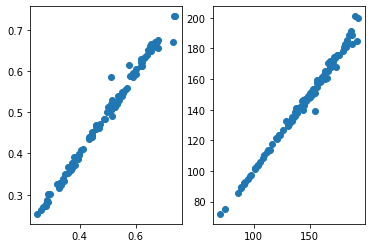

split: 1


__-------- CV models --------__

Optimizing Hyperparameters...
Restart |  HP0  |  HP1  |  HP2  |  HP3  |  HP4  |  nug  | 
 01/10  | 540.9 | +++++ | +++++ | +++++ | 318.1 | 0.001 |  *  f: 258.303
 02/10  | 1.379 | 26.69 | 3.646 | 0.434 | 1.381 | 0.053 |  *  f: 109.252
 03/10  | 1.379 | 26.69 | 3.646 | 0.434 | 1.381 | 0.053 |  *  f: 109.252
 04/10  | 1.396 | 30.75 | 3.111 | 0.604 | 1.212 | 0.053 |     f: 109.542
 05/10  | 1.379 | 26.69 | 3.646 | 0.434 | 1.381 | 0.053 |     f: 109.252
 06/10  | 1.395 | 30.75 | 3.111 | 0.604 | 1.212 | 0.053 |     f: 109.542
 07/10  | 1.379 | 26.69 | 3.646 | 0.434 | 1.381 | 0.053 |  *  f: 109.252
 08/10  | 1.379 | 26.69 | 3.646 | 0.434 | 1.381 | 0.053 |  *  f: 109.252
 09/10  | 1.379 | 26.69 | 3.646 | 0.434 | 1.381 | 0.053 |     f: 109.252
 10/10  | 1.379 | 26.69 | 3.646 | 0.434 | 1.381 | 0.053 |     f: 109.252

 08/10  | 1.379 | 26.69 | 3.646 | 0.434 | 1.381 | 0.053 |  *  f: 109.252
 (beta: 3.734 )
 (mucm sigma: 5.693040)
 (noise stdev: 0.303288)


Optimizing Hyperparameters...
Restart | 

__-------- APD models --------__

Optimizing Hyperparameters...
Restart |  HP0  |  HP1  |  HP2  |  HP3  |  HP4  |  nug  | 
 01/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |  *  f: 72.461
 02/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |  *  f: 72.461
 03/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |     f: 72.461
 04/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |     f: 72.461
 05/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |     f: 72.461
 06/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.336 | 0.048 |     f: 72.461
 07/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |     f: 72.461
 08/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |     f: 72.461
 09/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |     f: 72.461
 10/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |     f: 72.461

 02/10  | 4.403 | 1.515 | 2.631 | 0.449 | 0.335 | 0.048 |  *  f: 72.461
 (beta: 3.744 )
 (mucm sigma: 4.017032)
 (noise stdev: 0.190999)


Optimizing Hyperparameters...
Restart |  HP0  |  HP

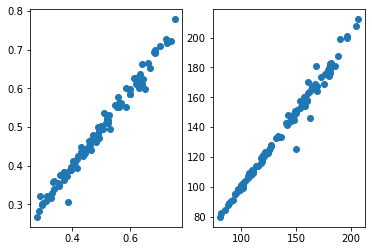

split: 2


__-------- CV models --------__

Optimizing Hyperparameters...
Restart |  HP0  |  HP1  |  HP2  |  HP3  |  HP4  |  nug  | 
 01/10  | 0.919 | 1.583 | 1.653 | 0.500 | 0.510 | 0.066 |  *  f: 67.963
 02/10  | 0.919 | 1.583 | 1.653 | 0.500 | 0.510 | 0.066 |  *  f: 67.963
 03/10  | 0.919 | 1.583 | 1.653 | 0.500 | 0.510 | 0.066 |  *  f: 67.963
 04/10  | 0.919 | 1.583 | 1.653 | 0.500 | 0.510 | 0.066 |  *  f: 67.963
 05/10  | 0.919 | 1.583 | 1.653 | 0.500 | 0.510 | 0.066 |     f: 67.963
 06/10  | 0.316 | 0.770 | 0.572 | 0.375 | 0.156 | ----- |     f: 96.552
 07/10  | 0.316 | 0.770 | 0.572 | 0.375 | 0.156 | ----- |     f: 96.552
 08/10  | 0.919 | 1.583 | 1.653 | 0.500 | 0.510 | 0.066 |     f: 67.963
 09/10  | 0.919 | 1.583 | 1.653 | 0.500 | 0.510 | 0.066 |  *  f: 67.963
 10/10  | 0.919 | 1.583 | 1.653 | 0.500 | 0.510 | 0.066 |     f: 67.963

 09/10  | 0.919 | 1.583 | 1.653 | 0.500 | 0.510 | 0.066 |  *  f: 67.963
 (beta: 0.785 )
 (mucm sigma: 2.872729)
 (noise stdev: 0.190833)


Optimizing Hyperparameters...
Restart |  HP0  |  HP

__-------- APD models --------__

Optimizing Hyperparameters...
Restart |  HP0  |  HP1  |  HP2  |  HP3  |  HP4  |  nug  | 
 01/10  | 6.755 | 10.26 | 4.829 | 0.543 | 0.137 | 0.008 |  *  f: -23.495
 02/10  | 32.28 | 0.379 | 2.188 | 1.035 | 0.269 | 0.008 |     f: 64.336
 03/10  | 6.755 | 10.26 | 4.829 | 0.543 | 0.137 | 0.008 |  *  f: -23.495
 04/10  | 6.755 | 10.26 | 4.830 | 0.543 | 0.137 | 0.008 |     f: -23.495
 05/10  | 6.755 | 10.26 | 4.829 | 0.543 | 0.137 | 0.008 |  *  f: -23.495
 06/10  | 6.754 | 10.26 | 4.829 | 0.543 | 0.137 | 0.008 |     f: -23.495
 07/10  | 6.755 | 10.26 | 4.830 | 0.543 | 0.137 | 0.008 |     f: -23.495
 08/10  | 6.755 | 10.26 | 4.829 | 0.543 | 0.137 | 0.008 |  *  f: -23.495
 09/10  | 6.755 | 10.26 | 4.830 | 0.543 | 0.137 | 0.008 |     f: -23.495
 10/10  | 6.755 | 10.26 | 4.829 | 0.543 | 0.137 | 0.008 |     f: -23.495

 08/10  | 6.755 | 10.26 | 4.829 | 0.543 | 0.137 | 0.008 |  *  f: -23.495
 (beta: 2.160 )
 (mucm sigma: 6.798139)
 (noise stdev: 0.056027)


Optimizing Hyperparameters...
Restart |  

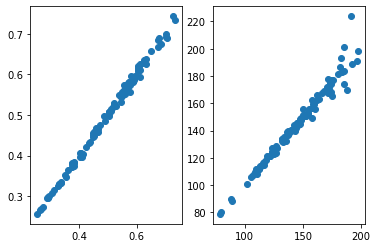

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state = 123)

R2CV  = np.empty((folds, pca_components_CV.shape[1]))
R2APD = np.empty((folds, pca_components_APD.shape[1]))
# R2ERP = np.empty((folds,2))

for split, (idx_train, idx_test) in enumerate(kf.split(features)): # loop over splits
    print("split:", split)

    # train the emulators
    printmd("__-------- CV models --------__")
    CVmodel = surrogatePCA_mucmgp(features[idx_train], table_coeffs_CV[idx_train],\
                                  pca_components_CV, pca_mean_CV)
#    CVmodel = surrogatePCA(features[idx_train], table_coeffs_CV[idx_train],\
#                                  pca_components_CV, pca_mean_CV)
    CVmodel.train(10, verbose = True)

    printmd("__-------- APD models --------__")
    APDmodel = surrogatePCA_mucmgp(features[idx_train], table_coeffs_APD[idx_train],\
                                   pca_components_APD, pca_mean_APD)

# using surrogatePCA produces linalg errors
#    APDmodel = surrogatePCA(features[idx_train], table_coeffs_APD[idx_train],\
#                                   pca_components_APD, pca_mean_APD)
    APDmodel.train(10, verbose = True)

#    printmd("__-------- ERP models --------__")
#    ERPmodel = surrogateERP_mucmgp(features[idx_train], both_ERP[idx_train])
#    ERPmodel.train(10, verbose = True, linearMean = True)

    
    # predictions
    pred_CV  = CVmodel.predict( features[idx_test])
    pred_APD = APDmodel.predict(features[idx_test])
#    pred_ERP = ERPmodel.predict(features[idx_test])
    
    # plot the high s2 predictions
    fig, ax = plt.subplots(1,2)
    ax[0].scatter(YDATA_CV[idx_test,-1], pred_CV[0][:,-1])
    ax[1].scatter(YDATA_APD[idx_test,-1], pred_APD[0][:,-1])
    #ax[2].scatter(YDATA_APD[idx_test,-1], pred_APD[0][:,-1])
    plt.show()
    #input("waiting")
    
    # compare
    for ss in range(R2CV.shape[1]):
        R2CV[split, ss]  = r2_score(YDATA_CV[idx_test,ss],  pred_CV[0][:,ss])
        R2APD[split, ss] = r2_score(YDATA_APD[idx_test,ss],  pred_APD[0][:,ss])
        
#    for ee in range(2):
#        R2ERP[split, ee] = r2_score(both_ERP[idx_test,ee],  pred_ERP[0][:,ee])